In [1]:
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [3]:
# dataset

x_train = np.array([[0, 0],
           [0, 1],
           [1, 0],
           [1, 1]])
y_train = np.array([[0],
           [1],
           [1],
           [0]])
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(4)

2022-05-13 00:25:25.673932: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# load data

samples = np.load("results_xor/results_5/sample_xor.npy", allow_pickle = True)
samples_hmc = samples[0]
samples_gibbs = samples[1]

In [5]:
# temporarily pick the HMC result of the first run

s_hmc = samples_hmc[0]
nets_hmc = [x['net'] for x in s_hmc]
weights_hmc = [x['weight'] for x in s_hmc]

In [6]:
nets_hmc[0][0][0]

<tf.Tensor: shape=(4, 32), dtype=float32, numpy=
array([[  76059.05  ,  -11851.887 ,  -75829.77  ,  118306.61  ,
        -180383.56  ,   33630.62  ,   31505.324 ,  -18127.475 ,
         -18753.363 , -171916.44  ,  132773.81  ,   71090.125 ,
         -96797.86  ,  -97523.86  ,   71270.92  , -108309.88  ,
         167068.5   , -106662.69  ,   24926.32  ,   30685.672 ,
          37659.406 ,   -1510.2878,    2459.9216,   29309.016 ,
          -3432.8118,  202034.62  ,  -18102.188 ,   36079.57  ,
          67480.08  ,   97895.55  ,    2792.8733, -123637.766 ],
       [-138847.8   ,   39015.227 , -192837.38  ,   -1486.7136,
          83306.766 ,   28235.484 ,   -5900.4473,  150299.69  ,
         106340.484 ,   47860.99  ,   17086.545 ,   55707.945 ,
        -140972.98  ,  -33288.33  ,  -49031.79  ,  -35432.934 ,
         -40494.97  ,   12167.823 ,   66519.02  ,   51486.164 ,
          60795.08  ,  -58686.477 ,  -41128.523 ,  -86298.33  ,
          61372.125 ,  -71805.17  ,  -83683.375 ,   42

In [55]:
weights_hmc[0][0][1]

array([ 1.4363123 , -0.94939584, -0.8542408 ,  0.8698301 , -1.4363093 ,
        1.4363672 ,  0.6755416 ,  0.01273539, -0.82262385, -0.96228385,
        0.6019154 ,  1.7996943 , -0.8613648 , -1.43632   ,  0.859649  ,
       -1.2227484 ,  0.8612935 , -0.9276784 ,  1.4091982 ,  1.4363098 ,
        1.4367057 , -2.581982  ,  0.85424364,  0.858604  , -1.4345229 ,
        0.8613513 , -1.4363353 ,  1.4695331 ,  1.4363761 ,  1.3179994 ,
        1.2049206 , -1.4497911 ], dtype=float32)

In [7]:
# replace values of nodes with 0 and 1
#nets_hmc  = [(np.sign(net[0][0].numpy())+1)/2 for net in nets_hmc]

# transfer to prob with sigmoid
probs_net_hmc = [tf.math.sigmoid(net[0][0]).numpy().T for net in nets_hmc]

In [30]:
avg = sum(probs_net_hmc) / 100
avg

array([[1.        , 0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [1.        , 0.86      , 1.        , 1.        ],
       [0.        , 1.        , 0.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [1.        , 1.        , 0.01016679, 1.        ],
       [1.        , 1.        , 1.        , 0.5099843 ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        ],
       [1.        , 0.        , 1.        , 1.        ],
       [0.        , 1.        ,

In [31]:
avg[avg > 0.5] = 1
avg[avg <= 0.5] = 0
avg = avg[((avg == 1) | (avg == 0)).all(axis = 1)]
avg.shape

(32, 4)

In [39]:
coef = np.array([8, 4, 2, 1])
tmp = (avg @ coef).astype("int64")
cnt = np.zeros(16)
idx = [[] for i in range(16)]

for i, x in enumerate(tmp):
    cnt[x] += 1
    idx[x].append(i)
    
print(cnt)
print(idx)

[3. 1. 2. 1. 3. 3. 1. 0. 2. 0. 3. 4. 2. 1. 0. 6.]
[[13, 26, 31], [21], [2, 12], [15], [8, 9, 17], [1, 4, 24], [7], [], [6, 22], [], [0, 29, 30], [14, 16, 23, 25], [19, 20], [10], [], [3, 5, 11, 18, 27, 28]]


In [40]:
tmp

array([10,  5,  2, 15,  5, 15,  8,  6,  4,  4, 13, 15,  2,  0, 11,  3, 11,
        4, 15, 12, 12,  1,  8, 11,  5, 11,  0, 15, 15, 10, 10,  0])

In [61]:
# calculate average weight for different nodes

output_weight = weights_hmc[0][0][1]
avg_weight = []

for ls in idx:
    
    if len(ls) != 0:
        avg_weight.append(sum([output_weight[i] for i in ls]) / len(ls))
    else:
        avg_weight.append(0)
        
avg_weight

[-1.4408154487609863,
 -2.581981897354126,
 -0.8578027784824371,
 -1.2227483987808228,
 -0.9041953682899475,
 -1.2734093467394512,
 0.012735392898321152,
 0,
 0.7648926079273224,
 0,
 1.3197441101074219,
 0.8602244555950165,
 1.436507761478424,
 0.6019154191017151,
 0,
 1.403499811887741]

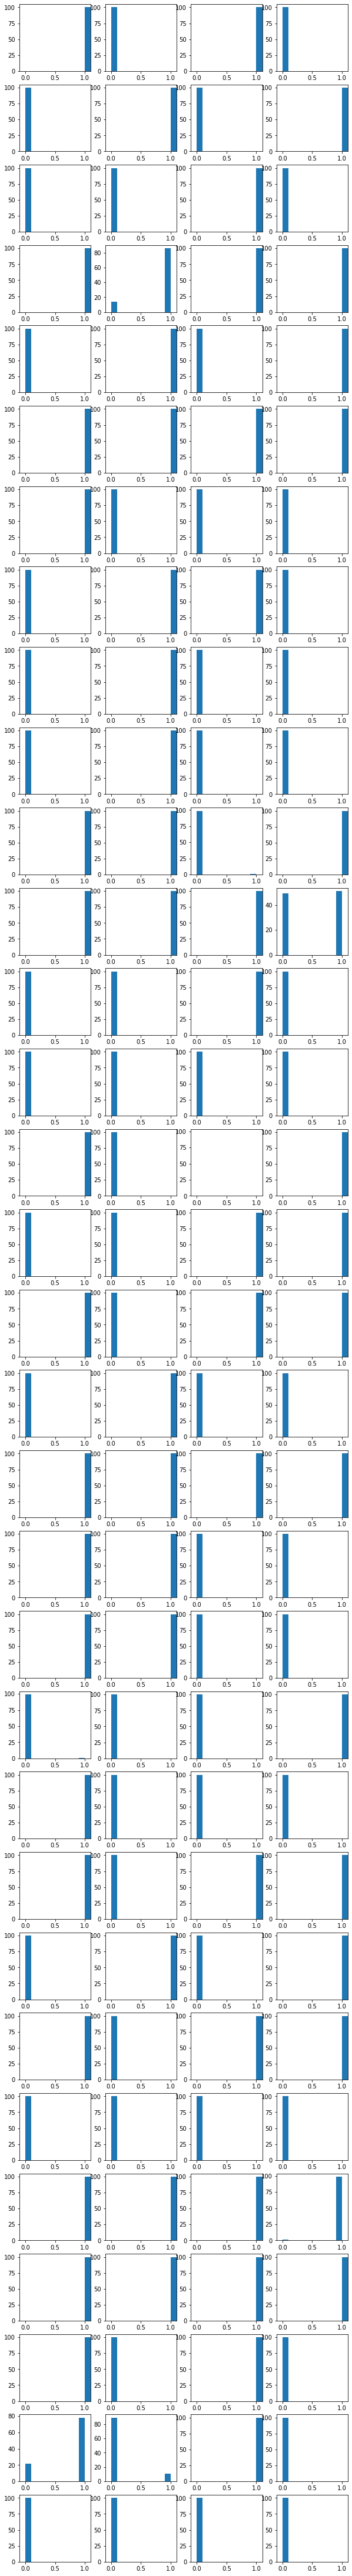

In [9]:
fig, ax = plt.subplots(nrows=32, ncols=4, figsize=(10, 80))
for i in range(32):
    
    samples_0 = [nodes[i][0] for nodes in probs_net_hmc]
    samples_1 = [nodes[i][1] for nodes in probs_net_hmc]
    samples_2 = [nodes[i][2] for nodes in probs_net_hmc]
    samples_3 = [nodes[i][3] for nodes in probs_net_hmc]
    
    ax[i, 0].hist(samples_0)
    ax[i, 1].hist(samples_1)
    ax[i, 2].hist(samples_2)
    ax[i, 3].hist(samples_3)
    
    ax[i, 0].set_xlim([-.1,1.1])
    ax[i, 1].set_xlim([-.1,1.1])
    ax[i, 2].set_xlim([-.1,1.1])
    ax[i, 3].set_xlim([-.1,1.1])

plt.show()

In [13]:
probs_net_hmc[5]

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 1., 1.],
       [0., 1., 0., 1.],
       [1., 1., 1., 1.],
       [1., 0., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 0., 1.],
       [1., 1., 1., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [1., 0., 1., 1.],
       [0., 0., 1., 1.],
       [1., 0., 1., 1.],
       [0., 1., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 1., 1.],
       [0., 1., 0., 1.],
       [1., 0., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [56]:
(15.99+7.99+1.39+7.19+3.79+13.49+22.78+33.23)*1.02+4.99*1.075

113.33125

In [57]:
1!=0

True